<a href="https://www.kaggle.com/code/hamdankhan212/car-price-prediction-raw-data?scriptVersionId=215590187" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/used-car-dataset-ford-and-mercedes/cclass.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/unclean cclass.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/focus.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/audi.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/toyota.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/skoda.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/ford.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/vauxhall.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/bmw.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/vw.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/hyundi.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/unclean focus.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/merc.csv


# Data Exploration

In [2]:
data = pd.read_csv('/kaggle/input/used-car-dataset-ford-and-mercedes/unclean cclass.csv')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4006 entries, 0 to 4005
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         3907 non-null   object 
 1   year          3904 non-null   float64
 2   price         3907 non-null   object 
 3   transmission  3907 non-null   object 
 4   mileage       3808 non-null   object 
 5   fuel type     1329 non-null   object 
 6   engine size   3842 non-null   object 
 7   mileage2      3890 non-null   object 
 8   fuel type2    3808 non-null   object 
 9   engine size2  3808 non-null   object 
 10  reference     3907 non-null   object 
dtypes: float64(1), object(10)
memory usage: 344.4+ KB
None


,model,year,price,transmission,mileage,fuel type,engine size,mileage2,fuel type2,engine size2,reference
0,C Class,2020.0,"£30,495",Automatic,NaN,Diesel,2,"1,200",NaN,NaN,/ad/25017331
1,C Class,2020.0,"£29,989",Automatic,NaN,Petrol,1.5,"1,000",NaN,NaN,/ad/25043746
2,C Class,2020.0,"£37,899",Automatic,NaN,Diesel,2,500,NaN,NaN,/ad/25142894
3,C Class,2019.0,"£30,399",Automatic,NaN,Diesel,2,"5,000",NaN,NaN,/ad/24942816
4,C Class,2019.0,"£29,899",Automatic,NaN,Diesel,2,"4,500",NaN,NaN,/ad/24913660


# Data Cleaning
The data is currently raw containing many issues such as false naming, missing entries, and unnecessary columns.
In order to make it usable for our objective of **Car Price Prediction**, we'll need to clean it.

Based on the exploration and metadata of the dataset, it seems:
* `reference` column is not needed, it serves no purpose to our objective
* `fuel type` does not have sufficient values. It has only *1329* entries in contrast to majority of other columns hacing *3800+*
* `fuel type2` can substitute `fuel type`, as it contains enough values.
* `mileage2` is actually the measure of miles per gallon of the car.
* `engine size` actually represents the road tax applied on the car in *£*(pounds).
* `engine size2` is the actual size of engine.

If you're wondering how I assumed most of the stuff out of thin air, it's because I chose this raw dataset out of a collection, which also contained some similar clean datasets with proper names and units. (Chose it for the sake of practicing data cleaning)

Dropping `reference` and `fuel type` columns.

In [3]:
data.drop(["reference","fuel type"], axis=1, inplace=True)

Renaming `fuel type2` to `fuel_type`, 
And `engine size2` to `engine_size`

In [4]:
data.rename(columns={'fuel type2': 'fuel_type'}, inplace=True)
data.rename(columns={'engine size2': 'engine_size'}, inplace=True)

Renaming `engine size` to `road_tax`, stripping the *£* sign off the values, and converting it to float datatype. Also filling the *nan* values with median.

In [5]:
data.rename(columns={'engine size':'road_tax'},inplace=True)
data["road_tax"].fillna(data["road_tax"].mode(), inplace=True)
data["road_tax"] = data["road_tax"].replace({'£':'','CC':''}, regex=True).astype("float")
data["road_tax"].fillna(data["road_tax"].median(),inplace=True)

Renaming `mileage2` to `miles_per_gallong` and cleaning the data.

In [6]:
data.rename(columns={'mileage2':'miles_per_gallon'}, inplace=True)
data = data[data["miles_per_gallon"]!="Unknown"]
data["miles_per_gallon"] = data["miles_per_gallon"].replace({',':''}, regex=True).astype("float")
data["miles_per_gallon"].fillna(data["miles_per_gallon"].median(),inplace=True)

Cleaning `engine_size` and converting it to float datatype.

In [7]:
data = data[data["engine_size"]!="Unknown"]
data["engine_size"] = data["engine_size"].replace({",":""},regex=True)
data["engine_size"] = data["engine_size"].astype("float")

Converting our target variable `price` to float datatype.

In [8]:
data["price"] = data["price"].replace({"£":"",",":""},regex=True).astype("float")

Cleaning and Converting `mileage` to float datatype. 

In [9]:
data = data[data["mileage"] != "Unknown"]
data["mileage"]  = data["mileage"].replace({",":""},regex=True).astype("float")

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4001 entries, 0 to 4005
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   model             3902 non-null   object 
 1   year              3899 non-null   float64
 2   price             3902 non-null   float64
 3   transmission      3902 non-null   object 
 4   mileage           3804 non-null   float64
 5   road_tax          4001 non-null   float64
 6   miles_per_gallon  4001 non-null   float64
 7   fuel_type         3804 non-null   object 
 8   engine_size       3804 non-null   float64
dtypes: float64(6), object(3)
memory usage: 312.6+ KB


Getting rid of incomplete rows.

In [11]:
data.dropna(inplace=True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3803 entries, 10 to 4005
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   model             3803 non-null   object 
 1   year              3803 non-null   float64
 2   price             3803 non-null   float64
 3   transmission      3803 non-null   object 
 4   mileage           3803 non-null   float64
 5   road_tax          3803 non-null   float64
 6   miles_per_gallon  3803 non-null   float64
 7   fuel_type         3803 non-null   object 
 8   engine_size       3803 non-null   float64
dtypes: float64(6), object(3)
memory usage: 297.1+ KB


# Data Splitting

Splitting the data into training and testing sets.

In [13]:
from sklearn.model_selection import train_test_split

X,Y = data.drop(["price"],axis=1),data["price"]

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=10)

# Data Visualization

array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'mileage'}>],
       [<Axes: title={'center': 'road_tax'}>,
        <Axes: title={'center': 'miles_per_gallon'}>],
       [<Axes: title={'center': 'engine_size'}>,
        <Axes: title={'center': 'price'}>]], dtype=object)

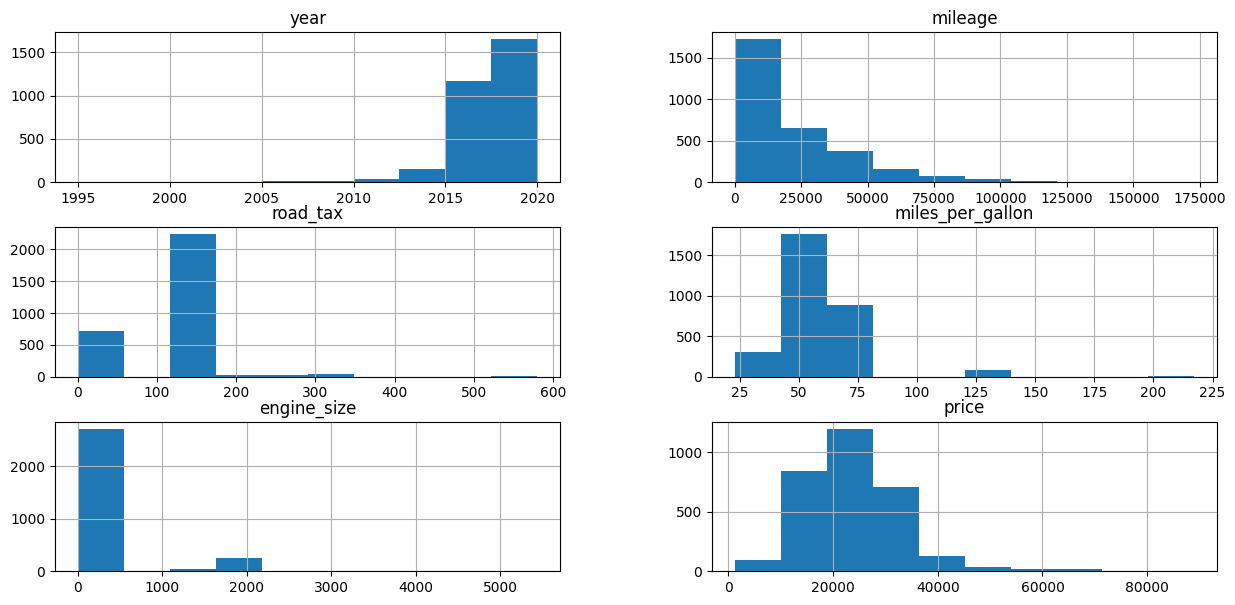

In [14]:
train_data = X_train.join(Y_train)
train_data.hist(figsize=(15,7))

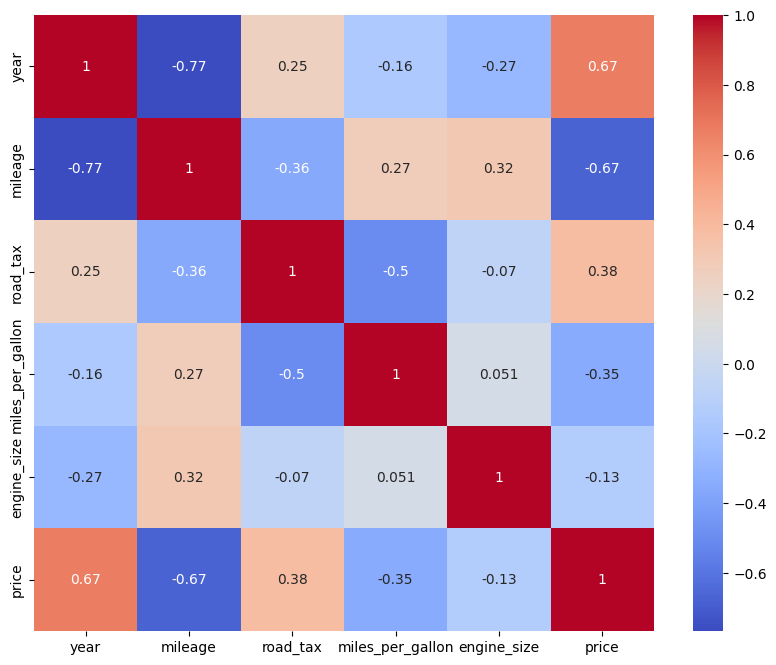

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

def generate_heatmap(data,figsize=(10,8)):
    numerical_columns = data.select_dtypes(include=["float64","int64"]).columns
    plt.figure(figsize=figsize)
    sns.heatmap(data[numerical_columns].corr(),annot=True,cmap="coolwarm")

generate_heatmap(train_data)

It seems that `price` is fairly correlated with all the features, except `engine_size`. 

We'll keep that in mind while enineering features in the later section.

# Data Preprocessing

Preprocessing the data will include:
* Feature scaling using log normalization of the features (`mileage`, `road_tax`, `miles_per_gallon`, `engine_size`)
* Converting the feature `year`, which denotes the year in which the car is registered, into `age` which represents the years that have passed since the registration in order to scale down the values.

In [16]:
train_data

,model,year,transmission,mileage,road_tax,miles_per_gallon,fuel_type,engine_size,price
2049,C Class,2019.0,Automatic,3268.0,145.0,42.2,Petrol,2.0,33199.0
3454,C Class,2016.0,Automatic,23196.0,30.0,65.7,Diesel,1598.0,16250.0
3201,C Class,2020.0,Automatic,3000.0,145.0,61.4,Diesel,1950.0,35900.0
499,C Class,2017.0,Semi-Auto,14346.0,145.0,65.7,Diesel,2.1,24360.0
689,C Class,2017.0,Semi-Auto,40993.0,125.0,60.1,Diesel,2.1,20150.0
...,...,...,...,...,...,...,...,...,...
3601,C Class,2019.0,Automatic,11287.0,145.0,58.9,Diesel,1600.0,22980.0
1456,C Class,2017.0,Automatic,46295.0,30.0,64.2,Diesel,2.1,19980.0
634,C Class,2019.0,Automatic,9985.0,145.0,57.7,Diesel,2.0,28887.0
3333,C Class,2018.0,Automatic,9705.0,145.0,64.2,Diesel,2.1,19999.0


In [17]:
def preprocess(data):
    data["mileage"] = np.log(data["mileage"]+1)
    data["road_tax"] = np.log(data["road_tax"]+1)
    data["miles_per_gallon"] = np.log(data["mileage"]+1)
    data["engine_size"] = np.log(data["engine_size"]+1)

    data["year"] = data["year"].max() - data["year"]
    data.rename(columns={"year":"age"},inplace=True)
    data["age"] = np.log(data["age"]+1)
    return data

In [18]:
train_data = preprocess(train_data)

<Axes: >

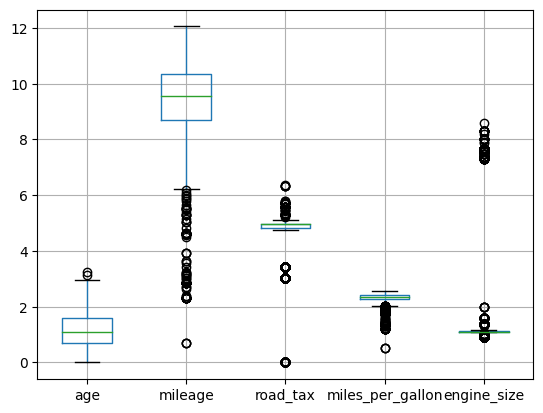

In [19]:
train_data.drop(["price"],axis=1).boxplot()

# Feature Engineering
### One-hot encoding

To be performed for columns: `model`, `transmission`, and `fuel_type`.

In [20]:
def one_hot_encode(data,feature): 
    new_features = pd.get_dummies(data[feature],dtype=int)
    data = data.join(new_features).drop([feature],axis=1)
    return data

def encode_features(data):
    data = one_hot_encode(data, "model")
    data = one_hot_encode(data, "transmission")
    data = one_hot_encode(data, "fuel_type")
    return data

In [21]:
train_data = encode_features(train_data)

The categorical features `model`, `transmission` and `fuel_type` are converted to integer columns using **One-hot encoding**.

In [22]:
train_data

,age,mileage,road_tax,miles_per_gallon,engine_size,price,C Class,Automatic,Manual,Semi-Auto,Diesel,Hybrid,Other,Petrol
2049,0.693147,8.092239,4.983607,2.207421,1.098612,33199.0,1,1,0,0,0,0,0,1
3454,1.609438,10.051778,3.433987,2.402591,7.377134,16250.0,1,1,0,0,1,0,0,0
3201,0.000000,8.006701,4.983607,2.197969,7.576097,35900.0,1,1,0,0,1,0,0,0
499,1.386294,9.571296,4.983607,2.358142,1.131402,24360.0,1,0,0,1,1,0,0,0
689,1.386294,10.621181,4.836282,2.452829,1.131402,20150.0,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3601,0.693147,9.331495,4.983607,2.335197,7.378384,22980.0,1,1,0,0,1,0,0,0
1456,1.386294,10.742811,3.433987,2.463241,1.131402,19980.0,1,1,0,0,1,0,0,0
634,0.693147,9.208939,4.983607,2.323264,1.098612,28887.0,1,1,0,0,1,0,0,0
3333,1.098612,9.180500,4.983607,2.320474,1.131402,19999.0,1,1,0,0,1,0,0,0


In [23]:
train_data[" C Class"].value_counts()

 C Class
1    3042
Name: count, dtype: int64

It seems the ` C Class` has a single value **1**. So it does not serve any purpose. 

We'll remove the ` C Class` and create 2 new features called:
* `miles_per_year` representing the average miles car has driven in a year, obtained by dividing `mileage` by `age` of the car.
* `engine_efficiency` representing the product of `miles_per_gallon` and `engine_size`.

In [24]:
def engineer_feature(data):
    data = data.drop([" C Class"],axis=1)
    data["miles_per_year"] = data["mileage"] / (data["age"]+0.1)
    data["engine_efficiency"] = data["miles_per_gallon"] * data["engine_size"]  
    return data

In [25]:
train_data = engineer_feature(train_data)

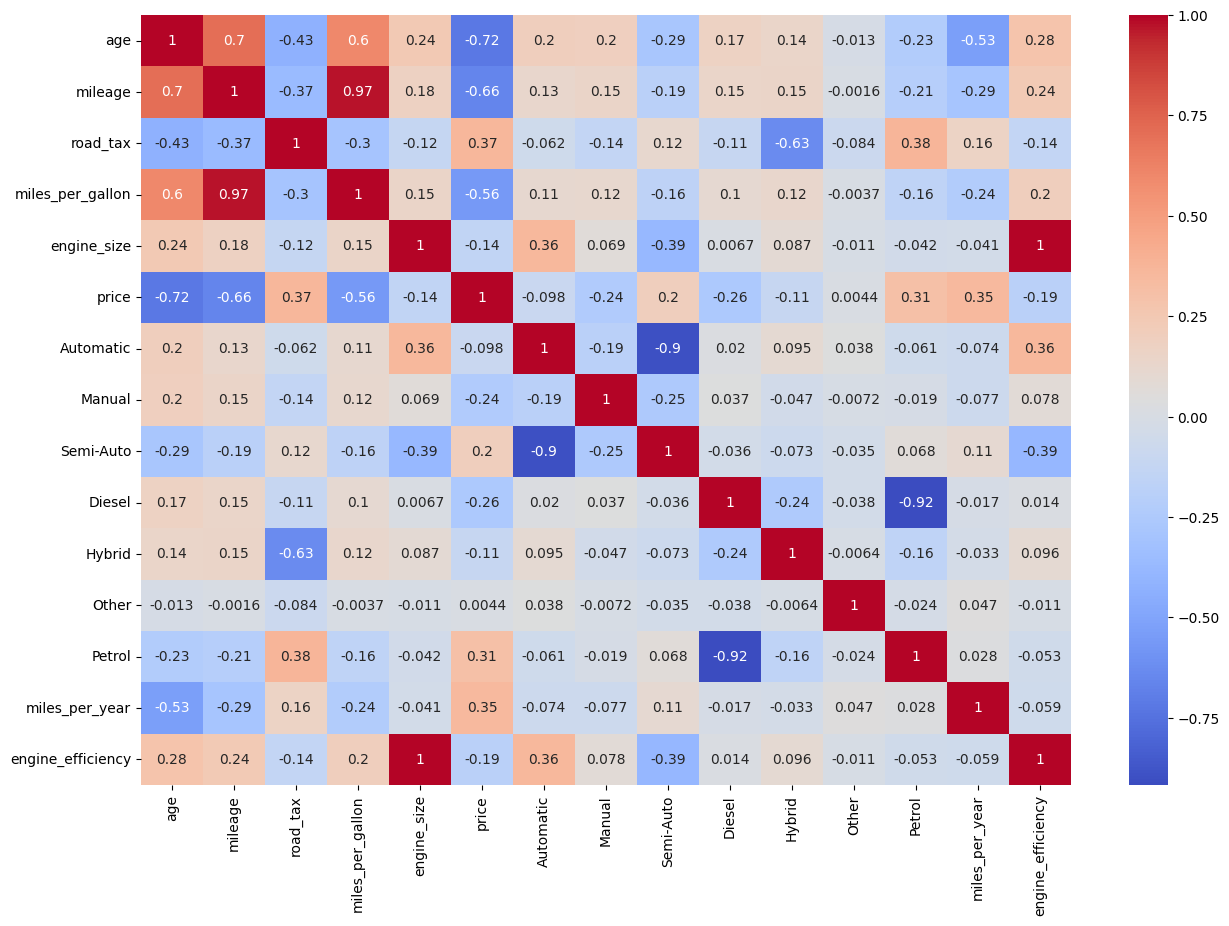

In [26]:
generate_heatmap(train_data,(15,10))

# Models

### Test data preparation
We'll prepare the test data in the same way we did train_data by:
* Data Preprocessing
* Feature Encoding
* Feature Engineering

In [27]:
test_data = X_test.join(Y_test)
test_data = preprocess(test_data)
test_data = encode_features(test_data)
test_data = engineer_feature(test_data)

test_data

,age,mileage,road_tax,miles_per_gallon,engine_size,price,Automatic,Manual,Semi-Auto,Diesel,Hybrid,Other,Petrol,miles_per_year,engine_efficiency
1157,0.693147,8.186743,4.983607,2.217761,1.098612,30492.0,1,0,0,0,0,0,1,10.321846,2.436460
2242,0.693147,7.693026,4.983607,2.162521,0.916291,27750.0,0,0,1,0,0,0,1,9.699367,1.981498
2348,0.000000,4.615121,4.983607,1.725463,1.098612,30500.0,0,0,1,1,0,0,0,46.151205,1.895615
3775,1.609438,10.170035,4.836282,2.413235,1.095608,13900.0,0,1,0,0,0,0,1,5.949345,2.643959
3163,0.693147,3.737670,5.017280,1.555545,7.311886,27498.0,1,0,0,0,0,0,1,4.712454,11.373971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,0.693147,2.397895,4.983607,1.223156,1.609438,57998.0,0,0,1,0,0,0,1,3.023266,1.968594
319,1.098612,8.878497,4.983607,2.290360,1.098612,26625.0,1,0,0,1,0,0,0,7.407314,2.516218
895,0.693147,9.593151,4.983607,2.360208,0.916291,23780.0,0,0,1,0,0,0,1,12.095045,2.162636
3370,1.609438,10.083891,3.433987,2.405493,1.131402,18499.0,1,0,0,1,0,0,0,5.898951,2.721580


In [28]:
train_data.columns == test_data.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

The columns of `train_data` and `test_data` match, hence they are compatible to fit and test for.

In [29]:
X_test, Y_test = test_data.drop(["price"],axis=1), test_data["price"]

## 1. Linear Regression

In [30]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

In [31]:
X_train, Y_train = train_data.drop(["price"],axis=1), train_data["price"]

reg.fit(X_train,Y_train)

LinearRegression()

In [32]:
reg.score(X_test,Y_test)

0.6415506271660876

## 2. Random Forest 

In [33]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [34]:
rf.fit(X_train,Y_train)

RandomForestRegressor(random_state=42)

In [35]:
rf.score(X_test,Y_test)

0.888379129058664